## Import needed libraries and declare function which plots bifurcation diagrams using file data

In [1]:
# Import all relevant libraries

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from pylab import *
from scipy import signal
from scipy.signal import argrelextrema
%matplotlib inline

def plot_bif_diagram(filename, direction):
    # Export data from the file
    df = pd.read_csv(filename, sep="\s+",header=None, names = ['x', 'y1', 'y2', 'stable', 'periodic', 'junk'])
    df.drop(columns = ['junk'], inplace = True)
    
    # Extract periodic branch
    periodic_branch = df[(df['periodic'] == 2)]
    
    # Extract bifurcation points and saveonly
    bifurcation_point = df[(df['stable']== 4)]
    #plt.plot(bifurcation_point.x, bifurcation_point.y2, '*k', ms = 10)

    # Extract non-periodic soulution,
    non_periodic_branch = df[(df['periodic']== 1)]

    # Separate unstable and stable branch using x-coordinates of bifurcation point   
    break_point = bifurcation_point.x.iloc[0]

    # Separate stable and unstable portion of non-periodic branch using break point.
    if direction == 'backward':
        break_index     = non_periodic_branch.index[non_periodic_branch.x <=break_point][-1]
        unstable_branch = non_periodic_branch.iloc[ break_index-1: ]
        stable_branch   = non_periodic_branch.iloc[:break_index    ]  
    else:
        if direction == 'forward':
            break_index     = non_periodic_branch.index[non_periodic_branch.x >=break_point][0]
            stable_branch   = non_periodic_branch.iloc[:break_index    ]
            unstable_branch = non_periodic_branch.iloc[ break_index-1: ] 
        else:
            sys.exit('incorrect diagram direction')
    
    # Plot all branches
    #fig, ax = plt.subplots()
    #ax.plot(x, y)
    plt.figure()
    #plt.plot(  stable_branch.x,   stable_branch.y1, 'k', lw =0.5)
    #plt.plot(unstable_branch.x, unstable_branch.y1, 'k', lw =0.5)   
    #plt.plot(periodic_branch.x, periodic_branch.y2, ':k')
    #plt.plot(periodic_branch.x, periodic_branch.y1, ':k')
    plt.plot(  stable_branch.x,   stable_branch.y1, 'k', lw =0.5)
    plt.plot(unstable_branch.x, unstable_branch.y1, 'k', lw =0.5)   
    plt.plot(periodic_branch.x, periodic_branch.y2, ':k')
    plt.plot(periodic_branch.x, periodic_branch.y1, ':k')
   
    
    return

## Plot/save bifurcation diagram for mRNA concentration vs light amplitude for strong oscillator, including 'C' label

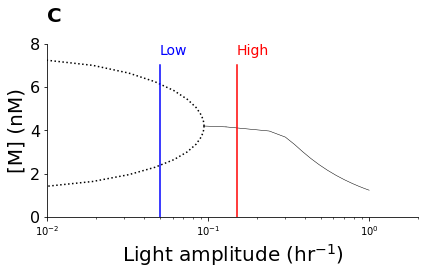

In [17]:
plot_bif_diagram("diagram-vs16.dat",'backward')

plt.xlabel('Light amplitude (hr$^{-1}$)',fontsize=20)
plt.ylabel('[M] (nM)',fontsize=20)

plt.yticks(ticks=(0,2,4,6,8),fontsize=16)
plt.ylim(0,8)
plt.xlim(0.01,2)
plt.xscale("log")

plt.plot((0.05, 0.05), (7, 0), 'b')
plt.plot((0.15, 0.15), (7, 0), 'r')
plt.text(0.05,7.5,'Low',color='b',fontsize=14)
plt.text(0.15,7.5,'High',color='r',fontsize=14)

plt.text(0.01,9,'C', fontsize=20, weight="bold")
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.tight_layout()
plt.savefig('Strong_osc_bifurc.jpeg',dpi=300)

## Plot/save bifurcation diagram for mRNA concentration vs light amplitude for weak oscillator, including 'D' label

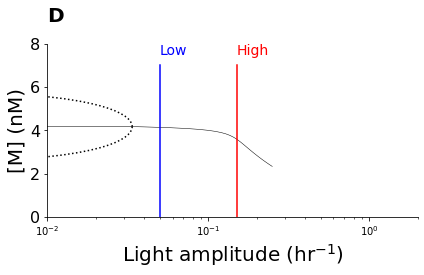

In [19]:
plot_bif_diagram("diagram_vs10.dat",'backward')

plt.xlabel('Light amplitude (hr$^{-1})$',fontsize=20)
plt.ylabel('[M] (nM)',fontsize=20)

plt.yticks(ticks=(0,2,4,6,8),fontsize=16)
plt.ylim(0,8)
plt.xlim(0.01,2)
plt.xscale("log")

plt.text(0.05,7.5,'Low',color='b',fontsize=14)
plt.text(0.15,7.5,'High',color='r',fontsize=14)
plt.plot((0.05, 0.05), (7, 0), 'b')
plt.plot((0.15, 0.15), (7, 0), 'r')

plt.text(0.01,9,'D', fontsize=20, weight="bold")
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.tight_layout()
plt.savefig('Weak_osc_bifurc.jpeg',dpi=300)

## Plot mRNA concentration oscillations affected by different const light amplitudes for strong oscillator

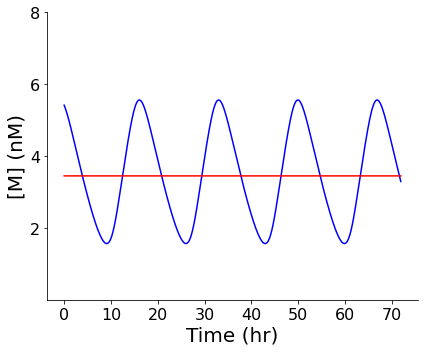

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jan 30 11:33:19 2020

@author: ntopo
"""

"""
Model of circadian oscillator with entraiment
"""
import numpy as np
import matplotlib as plt
from scipy.integrate import odeint
from pylab import *
from scipy import signal
from scipy.signal import argrelextrema
%matplotlib inline

#---------------------------------------------------------------------------------------------
#    Increasing hill function
#---------------------------------------------------------------------------------------------    
def hill_up(x, k, n):
    h = np.power(x,n)/(np.power(k,n) + np.power(x,n))
    return h

#---------------------------------------------------------------------------------------------
#    Decreasing hill function
#---------------------------------------------------------------------------------------------    
def hill_down(x, k, n):
    h = np.power(k,n)/(np.power(k,n) + np.power(x,n))
    return h

#---------------------------------------------------------------------------------------------
#    Generage a squate function of time series t with given period and amplitude
#---------------------------------------------------------------------------------------------
def square_wave(t, period, amp):
    wave = amp*signal.square(2 * np.pi * t/period)+amp
    return wave
            
#---------------------------------------------------------------------------------------------
#    Function defining differential equation for the model
#---------------------------------------------------------------------------------------------
def df(y, t):
    #assign input vector,y to variables of the model
    M  = y[0]
    PC = y[1]
    PN = y[2]
    
    # mRNA expression
    #dM =  vs*hill_down(PN, KI, 4) - vm*hill_up(M, Km, 1) - square_wave(t, light_period, light_amp)*M
    dM =  vs*hill_down(PN, KI, 4) - vm*hill_up(M, Km, 1) - light_amp*M
    # Protein concentration, PC - celllular, PN - nuclear
    dPC =   ks*M + k2*PN - k1*PC    - vd*hill_up(PC, Kd, 1)
    dPN =        - k2*PN + k1*PC
    # output right-hand side of differetial equations
    return [dM, dPC, dPN]

#---------------------------------------------------------------------------------------------
#    Find location and amplitude of peaks in a variable v with given timeline t
#---------------------------------------------------------------------------------------------
def find_peaks(t,v):
    # convert vontage trace into array
    v_array = np.array(v, dtype=np.float)
    # Find indices of local max(spikes)
    locs_max = argrelextrema(v_array, np.greater, order=2)[0]
    # Record spike times and max voltages in a dataframe
    peak_times = t[locs_max]
    peak_amp   = v[locs_max]
    return(peak_times, peak_amp)

#---------------------------------------------------------------------------------------------
#    Plot all variable of the model for the last plotting_time hours
#    Each plot is labeled by information in list names
#---------------------------------------------------------------------------------------------
def plot_non_transients(soln,dt, names, plotting_time, var_label):
    # Make time array for plotting
    t  = np.arange(0,plotting_time, dt)
    n_ind = len(t)
    n_subplots = len(variable_names)
    # For each variable in names list, plot last n_ind values versus time
    for i in range(0,n_subplots):
        variable = soln[-n_ind:,i]
        if (i==0):
            [p_times, p_amps] = find_peaks(t,variable)
    return p_times
#---------------------------------------------------------------------------------------------
#    Parameters of the model
#---------------------------------------------------------------------------------------------
vs = 1.6; vm = 0.505; Km = 0.5
KI = 1.0; ks = 0.2; vd = 1.4
Kd = 0.13; k1 = 0.5; k2 = 0.6
vs=1.6
light_amp = 1.0


#---------------------------------------------------------------------------------------------
#   Initial conditions
#---------------------------------------------------------------------------------------------
M0  = 0.89009363    
PC0 = 0.83699889
PN0 = 1.25723695
y0= [2.15404051, 3.19312247, 3.11948775] 

# Choose variable names for plotting
#variable_names = ['mRNA', 'Cytosol protein', 'Nuclear Protein']
variable_names = ['mRNA', 'PC', 'PN']

#---------------------------------------------------------------------------------------------
#   Run the simulation of the model 
#---------------------------------------------------------------------------------------------
# Choose total time of simulation, T
T = 3000.
# Chose time step
dt=0.05
# Make a time grid for the simulation
nsteps=int(T/dt)
t  = np.linspace(0, T, nsteps) 
# Chose number of simulation hours(last) which will be plotted
plotting_T = 72
t1  = np.arange(0,plotting_T, dt)
n_ind1 = len(t1)
ks = 0.3625  #period of 24 hr for strong oscillator
#light_amp_list = [0.00,0.05,0.15]
#color_list = ['k','b','r']
light_amp_list = [0.05,0.15]
color_list = ['b','r']
plt.figure(figsize = (6, 5))
for i in range(0,len(light_amp_list)):
    light_amp = light_amp_list[i]
    curr_color = color_list[i]
    # Solve DE for the model and plot the solution
    soln = odeint(df, y0, t)
    mrna = soln[-n_ind1:,0]
    plt.plot(t1,mrna,curr_color)
plt.ylabel('[M] (nM)',fontsize=20)
plt.xlabel('Time (hr)',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(ticks=(2,4,6,8),fontsize=16)
plt.ylim(0,8)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.tight_layout()
filename = 'strong-osc-in-const-light-traces.jpeg'
plt.savefig(filename,dpi=300)
plt.show()

## Add 'A' label to model diagram including light degradation 

In [12]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

mimage = Image.open('model-diagram-with-light.jpeg')

draw = ImageDraw.Draw(mimage)
font = ImageFont.truetype('arialbd', 82)
draw.text((37, 25),"A",fill = 'black', font = font)
mimage.save('model-diagram-with-light-A.jpeg')

## Add 'B' label to constant light traces panel

In [13]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

mimage = Image.open('strong-osc-in-const-light-traces.jpeg')

draw = ImageDraw.Draw(mimage)
font = ImageFont.truetype('arialbd', 82)
draw.text((37, 25),"B",fill = 'black', font = font)
mimage.save('strong-osc-in-const-light-traces-B.jpeg')

## Merge model diagram and const light traces into Figure 4 top panel

In [14]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
import numpy as np

images1 = [Image.open(x) for x in ['model-diagram-with-light-A.jpeg','strong-osc-in-const-light-traces-B.jpeg']]
widths1, heights1 = zip(*(i.size for i in images1))

avg_width1 = int(np.average(widths1))
avg_height1 = int(np.average(heights1))

print(avg_width1, avg_height1)

new_im = Image.new('RGB', (avg_width1*len(widths1), avg_height1))

x_offset = 0
for i in range(len(images1)):
    im2 = images1[i].resize((avg_width1,avg_height1))
    new_im.paste(im2, (x_offset,0))
    x_offset += avg_width1

new_im.save('Figure4-top.jpeg')

1800 1575


## Merge the two bifurcation diagrams into Figure 4 bottom panel

In [20]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
import numpy as np

images1 = [Image.open(x) for x in ['Strong_osc_bifurc.jpeg','Weak_osc_bifurc.jpeg']]
widths1, heights1 = zip(*(i.size for i in images1))

avg_width1 = int(np.average(widths1))
avg_height1 = int(np.average(heights1))

print(avg_width1, avg_height1)

new_im = Image.new('RGB', (avg_width1*len(widths1), avg_height1))

x_offset = 0
for i in range(len(images1)):
    im2 = images1[i].resize((avg_width1,avg_height1))
    new_im.paste(im2, (x_offset,0))
    x_offset += avg_width1

new_im.save('Figure4-bottom.jpeg')

1800 1200


## Merge upper and lower panels into full Figure 4

In [21]:
images = [Image.open(x) for x in ['Figure4-top.jpeg',  'Figure4-bottom.jpeg']]
widths, heights = zip(*(i.size for i in images))

avg_width = int(np.average(widths))
avg_height = int(np.average(heights))

print(avg_width, avg_height)

new_im = Image.new('RGB', (avg_width, avg_height*len(heights)))

y_offset = 0
for i in range(len(images)):
    im2 = images[i].resize((avg_width,avg_height))
    new_im.paste(im2, (0,y_offset))
    y_offset += avg_height

new_im.save('Figure4.jpeg')


3600 1387
